In [118]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Raw Code"></form>''')

# Telco Churn

## Goal: 
* Discover drivers of churn in the Telco data
* Use significant drivers to develop a machine learning model 

## Imports
- Pandas, Numpy
- Matplotlib & Seaborn
- Scipy & Scikit Learn
- `acquire` `prepare`

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare
import model

## Acquire

* Data was acquired using Pandas from the Codeup SQL Database
* Left Joined all tables for most amount of information
* It contained 7043 rows and 44 columns before cleaning
* Each row represents a customer
* Each column represents a feature of those customers

## Prepare

**Prepare Actions:**
* Removed columns that did not contain useful information
* Removed duplicate columns due to larger SQL Query
* Checked for nulls in the data (there were none)
* Checked that column data types were appropriate
* Fixed incorrect dtatypes
* Added additional features to investigate:
    * Total Add-on Count
* Encoded categorical bi-variate
* Created dummy variables for the multi-variate features
* Split data into train, validate and test (approx. 70/20/10), stratifying on 'churn'

### Data Dictionary

In [2]:
%%html
<style>
table {float:left}
</style>

| Feature | Definition |
|:--------|:-----------|
|customer_id| unique indentifier |
|gender| customer gender |
|senior_citizen| customer age status |
|dependents| customer total number of dependents |
|tenure| customer length of contract |
|phone_service| customer phone service status |
|multiple_lines| customer additional phone lines |
|online_security| does customer have online security |
|online_backup| does customer have online backup |
|device_protection| does customer have device protection |
|tech_support| does customer have tech suport |
|streaming_tv| does customer have streaming tv addon service |
|streaming_movies| does customer have streaming movies addon service |
|paperless_billing| does customer have paperless billing feature |
|monthly_charges| what customer pays every month |
|total_charges| sum of all monthly charges in tenure |
|churn| If customer left the company `churn` = 1, otherwise = 0 |
|internet_service_type| does customer have internet service |
|payment_type| customer form of payment for service |
|contract_type| does customer have monthly or annual contract |
| addon_sum | total count of additional service besides phone and internet|

In [3]:
# acquiring, cleaning, and adding features to data
df = acquire.get_telco_data()
df = prepare.clean_telco_data(df)

# splitting data into train, validate, and test
train, validate, test = prepare.split_telco_data(df)

### A brief look at the data

In [4]:
train.head(3)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
1611,2346-LOCWC,Female,0,Yes,Yes,58,Yes,No,No internet service,No internet service,...,0,1,0,0,1,0,1,1,0,0
1496,2205-LPVGL,Male,1,Yes,Yes,58,Yes,Yes,Yes,Yes,...,0,0,0,1,0,1,0,0,0,0
1689,2462-XIIJB,Male,0,No,No,5,Yes,Yes,No,No,...,1,0,0,0,0,1,0,0,1,0


### A summary of the data

In [5]:
train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
count,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,...,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000
mean,0.163302,32.663412,64.846738,3313.500244,0.497005,0.480142,0.301309,0.900821,0.591524,0.265365,...,0.384513,0.215221,0.392944,0.212114,0.242290,0.440648,0.215221,0.214555,0.340581,0.229199
std,0.369682,24.511510,30.132858,6973.584304,0.500047,0.499661,0.458878,0.298935,0.491606,0.441576,...,0.486534,0.411021,0.488459,0.408851,0.428516,0.496520,0.411021,0.410559,0.473957,0.420364
min,0.000000,0.000000,18.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.750000,429.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.200000,1505.900000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,56.000000,89.900000,4213.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,72.000000,118.750000,84050.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore

### 1. How often does churn occur? Out of?

In [6]:
churn_count = df[df['churn'] == "Yes"]['churn'].count()
total_churn_info = df['churn'].count()
print(f"Total churn = {churn_count} out of {total_churn_info} customers.")

Total churn = 1869 out of 7043 customers.


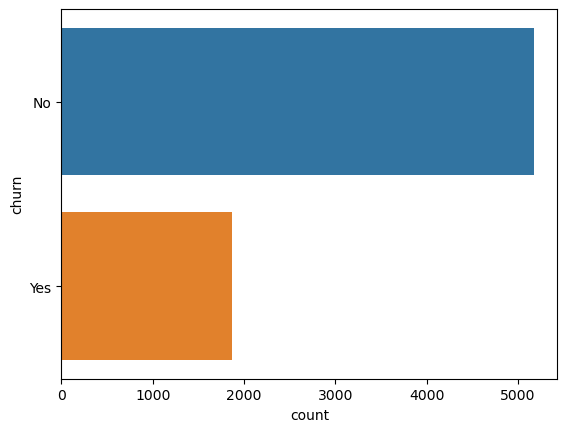

In [7]:
sns.countplot(data=df,y='churn')
plt.show()

In [8]:
df_pie = df.groupby(['churn'])['churn'].count().to_frame(name = 'count').reset_index()

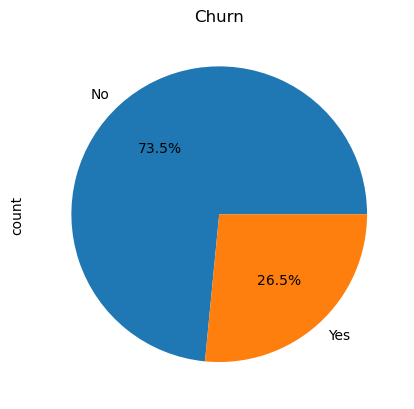

In [9]:
df_pie = df.groupby(['churn'])['churn'].count().to_frame(name = 'count').reset_index()
df_pie.set_index('churn', inplace=True)
df_pie.plot.pie(y='count', title="Churn", legend=False, \
                   autopct='%1.1f%%')
plt.show()

### 2. Are senior citizen more likely to churn?

Statistic Test:

**I will now use a chi-square test to investigate the question of whether `churn` is independent of being a `senior_citizen`.**
* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**- $H_{0}$ (Null Hypothesis): `churn` is independent of being a `senior_citizen`.**

**- $H_{a}$ (Alternative Hypothesis): `churn` is dependent on being a `senior_citizen`.**

In [10]:
group1='senior_citizen'
group2='churn'
observed = pd.crosstab(df[group1], df[group2])
alpha = 0.05
chi2, p, dof, expected = stats.chi2_contingency(observed)
observed_out = observed.values
expected_out = expected.astype(int)
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed_out)

# print --- and then a new line, 'Expected Values', followed by another new line
print('------\nExpected Values\n')

# print the expected values array
print(expected_out)

# print a new line
print('-----\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2: .4f}')

# print the p-value, formatted to a float with 4 digits. 
print(f'p-value = {p: .4f}')
print('Is p-value < alpha?', p < alpha)

prepare.eval_results(p, alpha, group1, group2)

Observed Values

[[4508 1393]
 [ 666  476]]
------
Expected Values

[[4335 1565]
 [ 838  303]]
-----

chi^2 =  159.4263
p-value =  0.0000
Is p-value < alpha? True


'There exists some relationship between senior_citizen and churn. (p-value: 0.0000)'

**Therefore, we have evidence to support that "`senior_citizen`" and "`churn`" are related. Based on this observed in the train data, I believe that using the "`senior_citizen`" feature in modeling will likely have a small positive impact on the model's accuracy.**

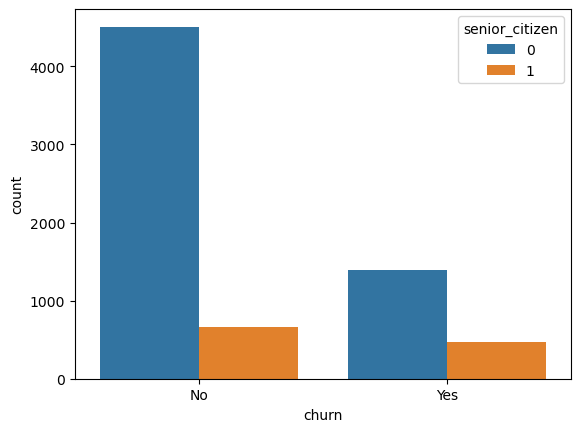

In [11]:
sns.countplot(data=df, x="churn", hue="senior_citizen")
plt.show()

### 3. Does added feature `total_addons` affect churn?

Statistic Test:

**I will now use a chi-square test to investigate if `total_addons` and `churn` are related.**
We will investigate the question of whether `total_addons` is independent of `churn`.

- $H_{0}$ (Null Hypothesis): `total_addons` is independent of `churn`. 

- $H_{a}$ (Alternative Hypothesis): `total_addons` is dependent on `churn`. 

In [12]:
addons = ['online_security','online_backup','device_protection', 'tech_support', 'streaming_tv','streaming_movies']
addon_sum=(df[addons]=='Yes').sum(axis=1)
df=df.assign(addon_sum=addon_sum)

group1='addon_sum'
group2='churn'

In [13]:
observed = pd.crosstab(df[group1], df[group2])
alpha = 0.05
chi2, p, dof, expected = stats.chi2_contingency(observed)
observed_out = observed.values
expected_out = expected.astype(int)
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed_out)

# print --- and then a new line, 'Expected Values', followed by another new line
print('------\nExpected Values\n')

# print the expected values array
print(expected_out)

# print a new line
print('-----\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2: .4f}')

# print the p-value, formatted to a float with 4 digits. 
print(f'p-value = {p: .4f}')
print('Is p-value < alpha?', p < alpha)

prepare.eval_results(p, alpha, group1, group2)

Observed Values

[[1744  475]
 [ 524  442]
 [ 663  370]
 [ 812  306]
 [ 662  190]
 [ 500   71]
 [ 269   15]]
------
Expected Values

[[1630  588]
 [ 709  256]
 [ 758  274]
 [ 821  296]
 [ 625  226]
 [ 419  151]
 [ 208   75]]
-----

chi^2 =  390.9430
p-value =  0.0000
Is p-value < alpha? True


'There exists some relationship between addon_sum and churn. (p-value: 0.0000)'

**The p-value is less than the alpha. Therefore, we have evidence to support that `addon_sum` and `churn` are related. Based on this observed in the train data, I believe that using the `addon_sum` feature in modeling will likely have a small positive impact on the model's accuracy.**

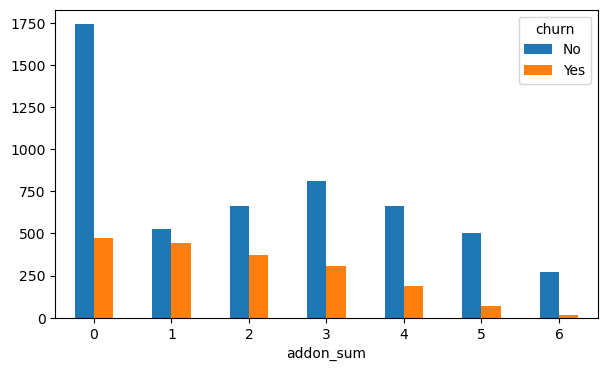

In [14]:
CrosstabResult=pd.crosstab(index=df[group1],columns=df[group2])
CrosstabResult.plot.bar(figsize=(7,4), rot=0)
plt.show()

### 4. Does `tech_support` affect churn?

**I will now use a chi-square test to investigate if `tech_support` and `churn` are related.**
We will investigate the question of whether `tech_support` is independent of `churn`.

- $H_{0}$ (Null Hypothesis): `tech_support` is independent of `churn`. 

- $H_{a}$ (Alternative Hypothesis): `tech_support` is dependent on `churn`. 

In [15]:
group1='tech_support'
group2='churn'

In [16]:
observed = pd.crosstab(df[group1], df[group2])
alpha = 0.05
chi2, p, dof, expected = stats.chi2_contingency(observed)
observed_out = observed.values
expected_out = expected.astype(int)
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed_out)

# print --- and then a new line, 'Expected Values', followed by another new line
print('------\nExpected Values\n')

# print the expected values array
print(expected_out)

# print a new line
print('-----\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2: .4f}')

# print the p-value, formatted to a float with 4 digits. 
print(f'p-value = {p: .4f}')
print('Is p-value < alpha?', p < alpha)

prepare.eval_results(p, alpha, group1, group2)

Observed Values

[[2027 1446]
 [1413  113]
 [1734  310]]
------
Expected Values

[[2551  921]
 [1121  404]
 [1501  542]]
-----

chi^2 =  828.1971
p-value =  0.0000
Is p-value < alpha? True


'There exists some relationship between tech_support and churn. (p-value: 0.0000)'

**The p-value is less than the alpha. Therefore, we have evidence to support that `tech_support` and `churn` are related. Based on this observed in the train data, I believe that using the `tech_support` feature in modeling will likely have a small positive impact on the model's accuracy.**

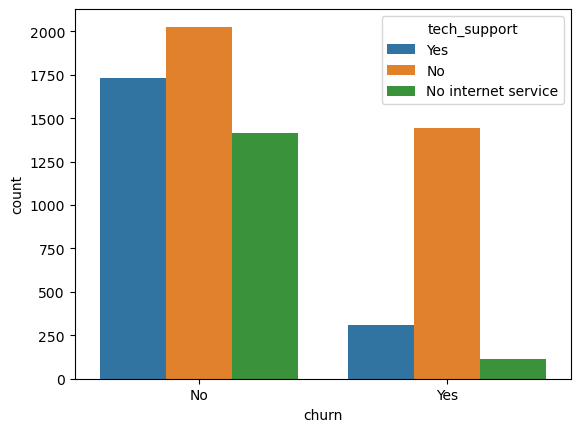

In [17]:
sns.countplot(data=df, x="churn", hue="tech_support")
plt.show()

### Exploration Summary
* "Senior Citizen Status" was found to be a driver of "churn"
* "Tech Support" was found to be a driver of "churn" 
* Added feature "Total Addons" was found to be a driver of "churn" 

### Features I am moving to modeling With
* "Senior Citizen Status" (small difference in churn percentage, but relationship to churn is statistically significant)
* "Tech Support" (small difference in churn percentage, but relationship to churn is statistically significant)
* "Total Addons" (moderate difference in churn percentage, and dependance is statistically significant)

## Modeling
* I used accuracy as my evaluation metric
</br>

* churn makes up 26.54% of the data 
* by guessing not churn for every customer one could achieve an accuracy of 73.46%
* 73.46% will be the baseline accuracy I use for this project
</br>

* I will be evaluating models developed using three different model types and various hyperparameter configurations 
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data 

In [30]:
train, validate, test = prepare.split_telco_data(df)

In [33]:
train_cust, validate_cust, test_cust = train['customer_id'],validate['customer_id'],test['customer_id']

In [35]:
X_train, y_train = prepare.model_telco_data(train)
X_validate, y_validate = prepare.model_telco_data(validate)
X_test, y_test = prepare.model_telco_data(test)

In [37]:
baseline = df['churn_encoded'].value_counts().idxmax()

### Random Forest

In [21]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
rf.fit(X_train, y_train)
RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

y_pred = rf.predict(X_train)
train_acc = pd.DataFrame()
train_acc['train_prediction']=y_pred
train_acc['actual']=y_train.tolist()
train_acc['baseline_prediction']=baseline
model_accuracy = (train_acc.train_prediction == train_acc.actual).mean()
baseline_accuracy = (train_acc.baseline_prediction == train_acc.actual).mean()

print(f'Random Forest accuracy: {model_accuracy:.2%} on training set')
print(f'     Baseline accuracy: {baseline_accuracy:.2%} on training set\n')


y_pred = rf.predict(X_validate)
validate_acc = pd.DataFrame()
validate_acc['validate_prediction']=y_pred
validate_acc['actual']=y_validate.tolist()
validate_acc['baseline_prediction']=baseline
model_accuracy = (validate_acc.validate_prediction == validate_acc.actual).mean()
baseline_accuracy = (validate_acc.baseline_prediction == validate_acc.actual).mean()

print(f'Random Forest accuracy: {model_accuracy:.2%} on validate set')
print(f'     Baseline accuracy: {baseline_accuracy:.2%} on validate set\n')

Random Forest accuracy: 79.05% on training set
     Baseline accuracy: 73.46% on training set

Random Forest accuracy: 78.17% on validate set
     Baseline accuracy: 73.47% on validate set



* Random Forest accuracy is higher than baseline for training and validate set

### Logistic Regression

In [38]:
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')
logit.fit(X_train, y_train)

y_pred = logit.predict(X_train)
train_acc = pd.DataFrame()
train_acc['train_prediction']=y_pred
train_acc['actual']=y_train.tolist()
train_acc['baseline_prediction']=baseline
model_accuracy = (train_acc.train_prediction == train_acc.actual).mean()
baseline_accuracy = (train_acc.baseline_prediction == train_acc.actual).mean()

print(f'Logistic Regression accuracy: {model_accuracy:.2%} on training set')
print(f'           Baseline accuracy: {baseline_accuracy:.2%} on training set\n')


y_pred = logit.predict(X_validate)
validate_acc = pd.DataFrame()
validate_acc['validate_prediction']=y_pred
validate_acc['actual']=y_validate.tolist()
validate_acc['baseline_prediction']=baseline
model_accuracy = (validate_acc.validate_prediction == validate_acc.actual).mean()
baseline_accuracy = (validate_acc.baseline_prediction == validate_acc.actual).mean()

print(f'Logistic Regression accuracy: {model_accuracy:.2%} on validate set')
print(f'           Baseline accuracy: {baseline_accuracy:.2%} on validate set\n')

Logistic Regression accuracy: 32.88% on training set
           Baseline accuracy: 73.46% on training set

Logistic Regression accuracy: 33.27% on validate set
           Baseline accuracy: 73.47% on validate set



* Logistic Regression is less accurate then baseline on training but slightly higher on validate set than training

### KNN

In [39]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_train)
train_acc = pd.DataFrame()
train_acc['train_prediction']=y_pred
train_acc['actual']=y_train.tolist()
train_acc['baseline_prediction']=baseline
model_accuracy = (train_acc.train_prediction == train_acc.actual).mean()
baseline_accuracy = (train_acc.baseline_prediction == train_acc.actual).mean()

print(f'     KNN accuracy: {model_accuracy:.2%} on training set')
print(f'Baseline accuracy: {baseline_accuracy:.2%} on training set\n')

y_pred = knn.predict(X_validate)
validate_acc = pd.DataFrame()
validate_acc['validate_prediction']=y_pred
validate_acc['actual']=y_validate.tolist()
validate_acc['baseline_prediction']=baseline
model_accuracy = (validate_acc.validate_prediction == validate_acc.actual).mean()
baseline_accuracy = (validate_acc.baseline_prediction == validate_acc.actual).mean()

print(f'     KNN accuracy: {model_accuracy:.2%} on validate set')
print(f'Baseline accuracy: {baseline_accuracy:.2%} on validate set\n')

     KNN accuracy: 83.56% on training set
Baseline accuracy: 73.46% on training set

     KNN accuracy: 76.75% on validate set
Baseline accuracy: 73.47% on validate set



* KNN model is 3.28% more accurate on validate set than baseline

### Comparing Models

* Out of the Random Forest, KNN, and Logistic Regression models Random Forest performed higher than baseline on train and validate
* The Logistic Regression model performed slightly better on validate data but was worse than baseline on either one.

* I have chosen to move forward to the test set with the Random Forest model

### Random Forest on Test

In [40]:
y_pred = knn.predict(X_test)
test_acc = pd.DataFrame()
test_acc['test_prediction']=y_pred
test_acc['actual']=y_test.tolist()
test_acc['baseline_prediction']=baseline
model_accuracy = (test_acc.test_prediction == test_acc.actual).mean()
baseline_accuracy = (test_acc.baseline_prediction == test_acc.actual).mean()

print(f'     KNN accuracy: {model_accuracy:.2%} on test set')
print(f'Baseline accuracy: {baseline_accuracy:.2%} on test set\n')

     KNN accuracy: 74.66% on test set
Baseline accuracy: 73.46% on test set



### Modeling Summary

* Out of the Random Forest, KNN, and Logistic Regression models Random Forest performed higher than baseline on train and validate
* The Logistic Regression model performed slightly better on validate data but was worse than baseline on either one.

## Conclusions

### Exploration

* Total churn = 1869 out of 7043 customers.
* 26.5% Churned
* 73.5% Not Churned

### Modeling

* Out of the Random Forest, KNN, and Logistic Regression models Random Forest performed higher than baseline on train and validate
* The Logistic Regression model performed slightly better on validate data but was worse than baseline on either one.

### Next Steps
* For loop chi square all categorical features against churn, and sort each feature by accuracy
* Explore further numerical features
* Look for other ways to calculate "Total Charges" Such as standard deviation from the mean and compare against churn

In [88]:
prediction_of_churn = knn.predict(X_test)
probability_of_churn = rf.predict_proba(X_test)
probability_of_churn=pd.DataFrame(data=probability_of_churn)

In [111]:
csv = pd.DataFrame()

In [112]:
csv['customer_id']=test_cust

In [113]:
csv['0']=probability_of_churn[0].tolist()
csv['1']=probability_of_churn[1].tolist()

In [114]:
csv['prediction_of_churn'] = prediction_of_churn

In [117]:
import os  
os.makedirs('folder/subfolder', exist_ok=True)  
csv.to_csv('folder/subfolder/out.csv')  